In [7]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

sys.path.append(parent_dir)

from simtrain import SETTINGS_POLIMI as SETTINGS
from simtrain.sim_models_new import Toy_intensity_Generator, Toy_intensity_Comparer
import torch
import torch.optim as optim
import torch.nn as nn

import paths
from os.path import join

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import simtrain.utils as utils
from tqdm import tqdm
import evotorch
import ray
from functools import partial

os.environ['PYTHONPATH'] = "/home/thahit/github/Recommender_Sim"
ray.init(ignore_reinit_error=True)


2024-08-09 15:20:18,263	INFO worker.py:1558 -- Calling ray.init() again after it has already been called.


Python version:,3.9.19
Ray version:,2.9.0
Dashboard:,http://127.0.0.1:8265


In [8]:

state_size = SETTINGS.STATE_SIZE
experiment_name = "toy"
#num_negatives = 100
#conditioned=True
#kl_weight=.01

In [3]:
sfaf

NameError: name 'sfaf' is not defined

# Data

In [ ]:
# parameter dicts
width= 8
user_state_dict = {"model_hyp": {"layer_width": [width, width]}}
intensity_state_dict = {"model_hyp": {"layer_width": [width, width],
                                                         "noise": 0}
                            }


hyperparameter_dict = {"state_size": state_size, "state_model": user_state_dict, 
                           "intensity_model": intensity_state_dict,# "num_recom" : num_items_per_recom,
                            "noise": 0.}
gen_model = Toy_intensity_Generator(hyperparameter_dict)

In [ ]:
path = join(paths.dat, SETTINGS.filepaths_new["simulate_intensity_model"]
            )
path

'/home/thahit/github/Recommender_Sim/dat/saved_models_polimi/simulate_intensity/gnerator_model.h5'

In [ ]:
#torch.save(gen_model.state_dict(), path)
gen_model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
state = torch.zeros((1, state_size))

In [ ]:
samples = [gen_model.sample_one(state).detach().numpy() for _ in range(100)]
samples = np.array(samples)
samples

TypeError: forward() got an unexpected keyword argument 'interval_time'

feed in true values for fake models, 


NameError: name 'samples' is not defined

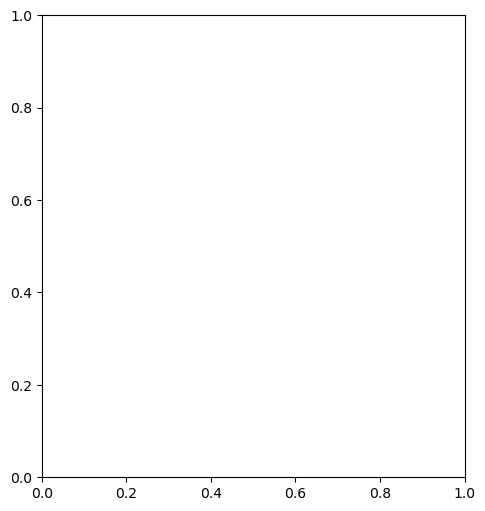

In [ ]:
plt.figure(figsize=(12, 6))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(samples, bins=50, density=True, alpha=0.6, color='g', edgecolor='black')
plt.title('Histogram of Samples')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Density Plot
plt.subplot(1, 2, 2)
sns.kdeplot(samples, shade=True, color='g', bw_adjust=0.1)
plt.title('Density Plot of Samples')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()


In [ ]:
sample_path = gen_model.sample_path(num_samples=5)
sample_path =torch.tensor(sample_path)
sample_path

TypeError: forward() got an unexpected keyword argument 'interval_time'

In [ ]:
#load actual data instead
checkpoint = torch.load(join(paths.dat, SETTINGS.rootpaths['models'],
                             "testing", "data.h5"))
list_of_dicts = checkpoint['data']
chosen_sample = list_of_dicts[4]["timestamps"]
sample_path =torch.tensor(chosen_sample)
sample_path

tensor([ 5.0833,  6.3958, 11.8125, 28.0417, 28.2708, 40.1042, 42.8542])

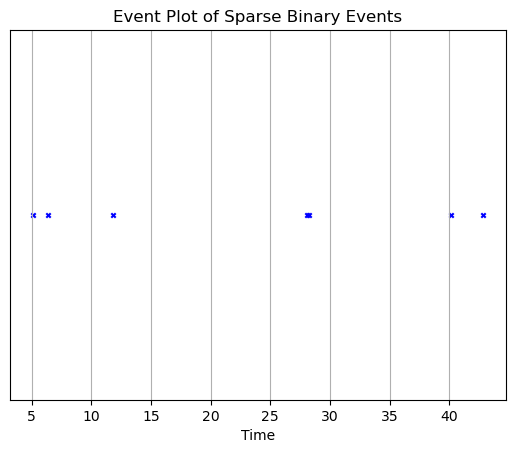

In [ ]:
#plt.eventplot(sample_path, orientation='vertical', colors='r')
plt.scatter(sample_path, [1] * len(sample_path), color='blue', label='Time Series 1', s=10, marker='x')

plt.yticks([])
plt.xlabel('Time')
plt.title('Event Plot of Sparse Binary Events')
plt.grid(True)
plt.show()


In [ ]:
asdafa

NameError: name 'asdafa' is not defined

# Model

In [9]:
checkpoint = torch.load(join(paths.dat, SETTINGS.rootpaths['models'],
                             "testing", "data.h5"))
list_of_dicts = checkpoint['data']
chosen_sample = list_of_dicts[4]["timestamps"]
sample_path =torch.tensor(chosen_sample)
sample_path

tensor([ 5.0833,  6.3958, 11.8125, 28.0417, 28.2708, 40.1042, 42.8542])

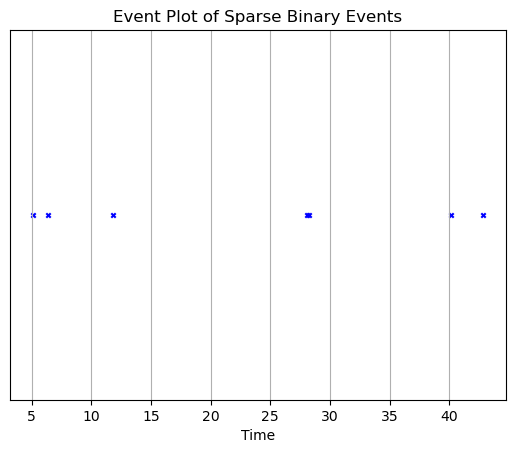

In [10]:
#plt.eventplot(sample_path, orientation='vertical', colors='r')
plt.scatter(sample_path, [1] * len(sample_path), color='blue', label='Time Series 1', s=10, marker='x')

plt.yticks([])
plt.xlabel('Time')
plt.title('Event Plot of Sparse Binary Events')
plt.grid(True)
plt.show()


## Train Gradient Descent
Not working

### base

In [ ]:
def train_single(model, path, scoring_func,optimizer, num_epochs=100, num_tries=20):
    
    for iter in tqdm(range(num_epochs)):
        last_t = 0
        state = torch.zeros((1, state_size))
        loss = 0.
        #results = []
        for timestep in path:
            current_pred = []
            for _ in range(num_tries):
                current_pred.append(last_t + model.sample_one(state))
            current_pred = torch.stack(current_pred)
            #results.append(torch.mean(current_pred))
            loss += torch.log(scoring_func(current_pred, timestep))
            delta = timestep-last_t
            last_t = timestep
            state = model.evolve_state(state, delta)
        print("loss: ", loss)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2)
        optimizer.step()

        #for name, param in model.named_parameters():
        #    print(f"Parameter Name: {name}")
        #    print(f"Parameter Value: {param}")
        #    print(f"Gradients: {param.grad}")
        #    print(f"Parameter Shape: {param.shape}")
        #    print(f"Requires Gradient: {param.requires_grad}")
        #    print("-" * 40)
        #return
        optimizer.zero_grad()


In [ ]:
# parameter dicts
width= 16
user_state_dict = {"model_hyp": {"layer_width": [width, width, width]}}
intensity_state_dict = {"model_hyp": {"layer_width": [width, width, width],
                                                         "noise": 0}
                            }


hyperparameter_dict = {"state_size": state_size, "state_model": user_state_dict, 
                           "intensity_model": intensity_state_dict,# "num_recom" : num_items_per_recom,
                            "noise": 0.}
train_model = Toy_intensity_Generator(hyperparameter_dict)

In [ ]:
path_train = join(paths.dat, SETTINGS.filepaths_new["copy_intensity_model"]
            )
#torch.save(gen_model.state_dict(), path_train)
#train_model.load_state_dict(torch.load(path_train))

In [ ]:
sample_path = torch.as_tensor(sample_path)
optimizer = optim.AdamW(train_model.parameters(), lr=0.1,
                        weight_decay=1e-7)


In [ ]:
#train_single(train_model, sample_path, scoring_func=utils.energy_score_loss,
#            optimizer=optimizer, num_epochs=30, num_tries=10)

### function approximation



In [ ]:
from simtrain.sim_models_new import all_in_one_model

width=64
user_state_dict = {"model_hyp": {"layer_width": [width, width, width, width]}}
time_dict = {"model_hyp": {"layer_width": [width, width, width, 3]}
                            }

timecheat = False
hyperparameter_dict = {"state_size": state_size, "time_model": time_dict, 
                           "state_model": user_state_dict}
train_model = all_in_one_model(hyperparameter_dict, timecheat=timecheat)

In [ ]:
def train_single_function_approx(model, path, scoring_func,optimizer, num_epochs=100, 
                                 num_tries=20, timecheat=False, loss_print_interval=1):
    
    for iter in tqdm(range(num_epochs)):
        last_t = 0
        state = torch.zeros((1, state_size))
        loss = 0.
        mse_loss = nn.MSELoss()
        #results = []
        for timestep in path:
            current_pred = []
            for _ in range(num_tries):
                if timecheat:
                    next_time = model.get_time(state, timestep)
                else:
                    next_time = model.get_time(state)
                #print(f"next_time: {next_time}, next_state: {next_state}")
                current_pred.append(last_t + next_time)
            current_pred = torch.stack(current_pred)
            last_t = timestep
            #results.append(torch.mean(current_pred))
            timestep = torch.Tensor([[timestep]])
            #print(torch.mean(current_pred))
            #loss = loss + mse_loss(next_time, timestep)
            loss += torch.log(scoring_func(current_pred, timestep)+1e-25)# + thing should be useless

            state = model.get_new_state(state, timestep)
        if iter %loss_print_interval == 0:
            print("loss: ", loss)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.)
        optimizer.step()

        #for name, param in model.named_parameters():
        #    print(f"Parameter Name: {name}")
        #    print(f"Gradients: {param.grad}")
        #    print(f"Parameter Value: {param}")
        #    print(f"Parameter Shape: {param.shape}")
        #    print(f"Requires Gradient: {param.requires_grad}")
        #    print("-" * 40)
        #return
        optimizer.zero_grad()

        #return results
    print("loss: ", loss)
    

In [ ]:
optimizer = optim.AdamW(train_model.parameters(), lr=0.1,
                        weight_decay=1e-7)

In [ ]:
train_single_function_approx(train_model, sample_path,scoring_func=utils.energy_score_loss,
            optimizer=optimizer, num_epochs=100, num_tries=20, timecheat=timecheat, loss_print_interval=10)

In [ ]:
optimizer = optim.AdamW(train_model.parameters(), lr=0.01,
                        weight_decay=1e-7)

In [ ]:
train_single_function_approx(train_model, sample_path,scoring_func=utils.energy_score_loss,
            optimizer=optimizer, num_epochs=200,timecheat=timecheat, num_tries=20, loss_print_interval=20)

In [ ]:
optimizer = optim.AdamW(train_model.parameters(), lr=0.001,
                        weight_decay=1e-7)

In [ ]:
train_single_function_approx(train_model, sample_path, scoring_func=utils.energy_score_loss,
            optimizer=optimizer, num_epochs=300,timecheat=timecheat, num_tries=20, loss_print_interval=20)

In [ ]:
optimizer = optim.AdamW(train_model.parameters(), lr=0.00001,
                        weight_decay=1e-7)

In [ ]:
train_single_function_approx(train_model, sample_path,scoring_func=utils.energy_score_loss,
            optimizer=optimizer, num_epochs=3000,timecheat=timecheat, num_tries=20, loss_print_interval=20)

In [ ]:
adsfasdf

### Predict intensities

In [11]:
train_sorted = False

In [12]:
width=64
user_state_dict = {"model_hyp": {"layer_width": [width, width, width, width]}}
time_dict = {"model_hyp": {"layer_width": [width, width, width, 3]}
            }

timecheat = False
hyperparameter_dict = {"state_size": state_size, "state_model": time_dict, 
                           "intensity_model": user_state_dict}
model = Toy_intensity_Comparer(hyperparameter_dict)

In [13]:
# create dataset

import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader


class TimestepFrequencyDataset(Dataset):
    def __init__(self, timesteps, num_random_points=100, interval=0.5, max_time=70):
        """
        Args:
            timesteps (numpy array): Array of positive timesteps.
            num_random_points (int): Number of random points to generate.
            interval (float): Interval length to compute frequency.
            max_time (float): maximum time the dataset is allowed to contain.
        """
        self.timesteps = np.array(timesteps)
        self.num_random_points = num_random_points
        self.interval = interval
        
        # Generate random time points and ensure they include actual timesteps
        self.max_time = max_time
        self.random_points = np.sort(np.random.uniform(0, self.max_time, self.num_random_points))
        self.unique_points = np.unique(np.concatenate([self.random_points, self.timesteps]))
        
        # Calculate frequencies for each point
        self.frequencies = np.array([self.calculate_frequency(point) for point in self.unique_points])
        
    def calculate_frequency(self, point):
        """
        Calculate frequency of events in the interval [point, point + interval).
        
        Args:
            point (float): The point to calculate frequency for.
        
        Returns:
            float: Frequency of events per interval.
        """
        # could be made more efficient by using the input is sorted
        count = np.sum(np.abs(self.timesteps - point) <= self.interval/2)
        frequency = count / self.interval
        return frequency
    
    def __len__(self):
        return len(self.unique_points)
    
    def __getitem__(self, idx):
        """
        Get item at index `idx`.
        
        Args:
            idx (int): Index of the item to fetch.
        
        Returns:
            dict: A dictionary with 'timestep' and 'frequency'.
        """
        timestep = self.unique_points[idx]
        frequency = self.frequencies[idx]
        return {'timestep': torch.tensor(timestep, dtype=torch.float32),
                'frequency': torch.tensor(frequency, dtype=torch.float32)}

# Example usage
dataset = TimestepFrequencyDataset(sample_path)

# Accessing items from the dataset
for i in range(min(len(dataset), 10)):
    sample = dataset[i]
    print(f"Timestep: {sample['timestep'].item():.5f}, Frequency: {sample['frequency'].item()}")

dataloader = DataLoader(dataset, batch_size=16, shuffle=not train_sorted)

Timestep: 0.60017, Frequency: 0.0
Timestep: 1.60785, Frequency: 0.0
Timestep: 2.14246, Frequency: 0.0
Timestep: 2.14698, Frequency: 0.0
Timestep: 2.38306, Frequency: 0.0
Timestep: 3.01250, Frequency: 0.0
Timestep: 3.02679, Frequency: 0.0
Timestep: 3.11503, Frequency: 0.0
Timestep: 4.10295, Frequency: 0.0
Timestep: 4.29317, Frequency: 0.0


In [14]:
optimizer = optim.AdamW(model.parameters(), lr=0.01,
                        weight_decay=1e-7)

In [15]:
def train_density(model, dataloader, criterion, optimizer, state_size, num_epochs=100, 
        loss_print_interval=1):
    
    for iter in tqdm(range(num_epochs)):
        loss_sum = .0
        
        for batch in dataloader:
            timesteps = batch['timestep'].unsqueeze(1)  # Add batch dimension
            frequencies = batch['frequency']
            state = torch.zeros((len(timesteps), state_size))
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(state, timesteps)

            loss = criterion(outputs, frequencies)  # Remove extra dimension from output
            loss_sum += loss.item()
            print(f"loss: {loss} \tfrequencies: {frequencies} \t predicted: {outputs}")
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.)
            optimizer.step()    

            for name, param in model.named_parameters():
                print(f"Parameter Name: {name}")
                print(f"Gradients: {param.grad}")
        if iter % loss_print_interval == 0:
            print(f"epch: {iter} loss_sum: {loss_sum :.4f}")
        

def train_density_sorted():
    pass

In [16]:
train_density(model, dataloader, criterion=nn.MSELoss(), state_size=state_size,
               optimizer=optimizer, num_epochs=2)

  0%|          | 0/2 [00:00<?, ?it/s]/home/thahit/anaconda3/envs/WW2/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/thahit/anaconda3/envs/WW2/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 2/2 [00:00<00:00, 22.62it/s]

tensor([[-2852.1882,  2765.2644,   171.1403,   968.2811],
        [-2132.9348,  2065.0857,   126.1791,   724.3677],
        [-1629.7666,  1574.5975,    94.2588,   553.8027],
        [-2912.3013,  2823.7524,   174.8764,   988.6699],
        [-1398.6831,  1349.1907,    79.4961,   475.4850],
        [ -117.1047,   144.8941,    29.8103,    36.3426],
        [ -514.5488,   505.0840,    35.8804,   173.9211],
        [-3832.7124,  3718.8940,   231.8077,  1300.8900],
        [-1489.8555,  1438.1182,    85.3170,   506.3852],
        [-3635.9739,  3527.5869,   219.6597,  1234.1495],
        [ -276.6954,   295.0114,    36.1031,    91.0118],
        [  -56.6416,    64.5259,    10.9144,    18.0905],
        [ -806.1091,   779.2067,    47.2853,   273.8113],
        [ -364.4576,   378.0250,    39.8875,   121.0273],
        [-2172.4922,  2103.6145,   128.6663,   737.7803],
        [-2599.5205,  2519.3813,   155.4048,   882.5876]],
       grad_fn=<AddmmBackward0>)
loss: 2855264321536.0 	frequencies: te

## Train via Evolution

In [ ]:
from evotorch.algorithms import PGPE, CMAES
from evotorch.logging import PandasLogger
from functools import partial


In [ ]:
# parameter dicts
width= 64
user_state_dict = {"model_hyp": {"layer_width": [width,width, width]}}
intensity_state_dict = {"model_hyp": {"layer_width": [width, width,width],
                                                         "noise": 0}
                            }


hyperparameter_dict = {"state_size": state_size, "state_model": user_state_dict, 
                           "intensity_model": intensity_state_dict,# "num_recom" : num_items_per_recom,
                            "noise": 0.}
train_model = Toy_intensity_Generator(hyperparameter_dict)

In [ ]:
path_train = join(paths.dat, SETTINGS.filepaths_new["copy_intensity_model"]
            )
#torch.save(gen_model.state_dict(), path_train)
#train_model.load_state_dict(torch.load(path_train))

In [ ]:

def eval_single(model, path, scoring_func, num_tries=20):
    
    last_t = 0
    state = torch.zeros((1, state_size))
    loss = 0.
    #results = []
    with torch.no_grad():
        for timestep in path:
            current_pred = []
            for _ in range(num_tries):
                out = model.sample_one(state)
                current_pred.append(last_t + out)
            current_pred = torch.stack(current_pred)
            #results.append(torch.mean(current_pred))
            loss += scoring_func(current_pred, timestep)
            delta = timestep-last_t
            last_t = timestep
            state = model.evolve_state(state, delta)
    
    return loss


eval_single_partial = partial(eval_single, path=sample_path, scoring_func=utils.energy_score_loss,
                              num_tries=30)

In [ ]:
eval_single_partial(train_model)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Single_path_problem = evotorch.neuroevolution.NEProblem(
    objective_sense="min",
    network= train_model,
    #network=Toy_intensity_Generator,
    #network_args = {"hyperparameter_dict": hyperparameter_dict},
    network_eval_func=eval_single_partial,
    device=device,
    num_actors = 20,
)

In [ ]:


searcher = PGPE(
    Single_path_problem,
    popsize=40,
    radius_init=5.,
    center_learning_rate=0.2,
    stdev_learning_rate=0.05,
)
'''
searcher = CMAES(
    Single_path_problem,
    popsize=20,  
    stdev_init= 2.
)'''

logger = PandasLogger(searcher)



In [ ]:
num_iterations = 20
for _ in tqdm(range(num_iterations), desc="Running PGPE"):
    searcher.step()

1 epoch = 50(population) * 20(samples for expectation) * 1(number of paths) * 10'000(integration/for loop steps, worst case) * (2+1) (neural network calls) *10(number of events)= 300m NN calls per epoch

for much worse approximation and still way too much compute:<br>
1 epoch = 20(population) * 20(samples for expectation) * 1(number of paths) * 100(integration/for loop steps, worst case) * (2+1) (neural network calls) *10(number of events)= 1.2m NN calls per epoch


lstm/rnn  feed last hidden state + actual state to predict probability increase,  stop at  threshhold chosen by uniform 


neural network(time? + state)  -> time + state

noise for time but not state

normalizing flows?

In [ ]:
logger.to_dataframe().mean_eval.plot()# test datapoint CMA ES

In [ ]:
asdcas

In [ ]:
trained_network = Single_path_problem.parameterize_net(searcher.status["center"])


In [ ]:
path_train = join(paths.dat, SETTINGS.filepaths_new["copy_intensity_model"]
            )
#torch.save(trained_network.state_dict(), path_train)
#train_model.load_state_dict(torch.load(path_train))
#trained_network = train_model

# Visualize

In [ ]:
trained_network = train_model

In [ ]:

def simulate_single_forced(model, path, num_tries=20):
    
    last_t = 0
    state = torch.zeros((1, state_size))
    results = []
    with torch.no_grad():
        for timestep in path:
            current_pred = []
            for _ in range(num_tries):
                out = model.sample_one(state)
                current_pred.append(last_t + out)
            current_pred = torch.stack(current_pred)
            results.append(torch.mean(current_pred))
            print(f"var(forced): {torch.var(current_pred)}")
            #loss += scoring_func(current_pred, timestep)
            delta = timestep-last_t
            last_t = timestep
            state = model.evolve_state(state, delta)
    
    return results

def simulate_single_forced_function_approx(model, path, 
                                           timecheat=False, num_tries=20):
    
    last_t = 0
    state = torch.zeros((1, state_size))
    results = []
    with torch.no_grad():
        for timestep in path:
            current_pred = []
            for _ in range(num_tries):
                if timecheat:
                    next_time=model.get_time(state, timestep)
                else:
                    next_time=model.get_time(state)
                #print(f"next_time: {next_time}, next_state: {next_state}")
                current_pred.append(last_t + next_time[0])
            current_pred = torch.stack(current_pred)
            results.append(torch.mean(current_pred))
            last_t = timestep
            state = model.get_new_state(state, torch.tensor([[timestep]]))
    
    return results

def simulate_single_function_approx(model, path, timecheat=False, num_tries=20):
    
    last_t = 0
    state = torch.zeros((1, state_size))
    results = []
    with torch.no_grad():
        for timestep in path:
            current_pred = []
            for _ in range(num_tries):
                if timecheat:
                    next_time=model.get_time(state, timestep)
                else:
                    next_time=model.get_time(state)
                
                current_pred.append(last_t + next_time[0])
            current_pred = torch.stack(current_pred)
            selected = torch.mean(current_pred)
            results.append(selected)
            last_t = selected
            state = model.get_new_state(state, torch.tensor([[selected]]))
    
    return results

def simulate_single(model, num_events, num_tries=20):
    
    last_t = 0
    state = torch.zeros((1, state_size))
    results = []
    with torch.no_grad():
        for i in range(num_events):
            current_pred = []
            for _ in range(num_tries):
                out = model.sample_one(state)
                current_pred.append(last_t + out)
            current_pred = torch.stack(current_pred)
            print(f"var: {torch.var(current_pred)}")
            selected = torch.mean(current_pred)
            results.append(selected)
            delta = selected-last_t
            last_t = selected
            state = model.evolve_state(state, delta)
    
    return results


In [ ]:
# simpler nn
simulate_single_partial_forced_function_approx = partial(
    simulate_single_forced_function_approx, path=sample_path,
                              num_tries=30, timecheat=timecheat)
simulate_single_partial_function_approx =partial(
    simulate_single_function_approx, path=sample_path,
                              num_tries=30, timecheat=timecheat)

In [ ]:
# integrals
simulate_single_partial_forced = partial(simulate_single_forced, path=sample_path, 
                              num_tries=2)

simulate_single_partial = partial(simulate_single, num_events=12,
                              num_tries=2)


In [ ]:
example_out_forced = simulate_single_partial_forced(trained_network)
example_out = simulate_single_partial(trained_network)

In [ ]:
#mlp
example_out_forced = simulate_single_partial_forced_function_approx(trained_network)
example_out = simulate_single_partial_function_approx(trained_network)

In [ ]:

import matplotlib.pyplot as plt

# Example data: replace these with your actual time series data
time_series_1 = sample_path # Timestamps for the first time series
time_series_2 = torch.clamp(torch.as_tensor(example_out_forced),0,70).detach().numpy()  # Timestamps for the second time series
time_series_3 = torch.clamp(torch.as_tensor(example_out), 0, 70).detach().numpy()  # Timestamps for the second time series


# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the first time series
ax.scatter(time_series_1, [1] * len(time_series_1), color='blue', label='Ground Truth', s=10, marker='o')

# Plot the second time series
ax.scatter(time_series_2, [2] * len(time_series_2), color='red', label='Simmulation Forced', s=10, marker='x')

ax.scatter(time_series_3, [3] * len(time_series_3), color='green', label='Simmulation Free', s=10, marker='x')


# Add labels, legend, and grid
ax.set_xlabel('Time')
ax.set_yticks([1, 2, 3])
ax.set_yticklabels(['Ground Truth', 'Simmulation Forced', "Simmulation Free"])
ax.set_title('Comparison of Two Time Series')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

# Adjust subplot parameters to make room for the legend
plt.subplots_adjust(right=0.75)
ax.grid(True)

# Display the plot
plt.show()


In [ ]:
asdfasf

In [ ]:
# 3 layers
import matplotlib.pyplot as plt

# Example data: replace these with your actual time series data
time_series_1 = sample_path # Timestamps for the first time series
time_series_2 = torch.clamp(torch.as_tensor(example_out_forced),0,70).detach().numpy()  # Timestamps for the second time series
time_series_3 = torch.clamp(torch.as_tensor(example_out), 0, 70).detach().numpy()  # Timestamps for the second time series


# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the first time series
ax.scatter(time_series_1, [1] * len(time_series_1), color='blue', label='Ground Truth', s=10, marker='o')

# Plot the second time series
ax.scatter(time_series_2, [2] * len(time_series_2), color='red', label='Simmulation Forced', s=10, marker='x')

ax.scatter(time_series_3, [3] * len(time_series_3), color='green', label='Simmulation Free', s=10, marker='x')


# Add labels, legend, and grid
ax.set_xlabel('Time')
ax.set_yticks([1, 2, 3])
ax.set_yticklabels(['Ground Truth', 'Simmulation Forced', "Simmulation Free"])
ax.set_title('Comparison of Two Time Series')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

# Adjust subplot parameters to make room for the legend
plt.subplots_adjust(right=0.75)
ax.grid(True)

# Display the plot
plt.show()


In [ ]:
SCA

In [ ]:

import matplotlib.pyplot as plt

# Example data: replace these with your actual time series data
time_series_1 = sample_path # Timestamps for the first time series
time_series_2 = torch.clamp(torch.as_tensor(example_out_forced),0,70).detach().numpy()  # Timestamps for the second time series
time_series_3 = torch.clamp(torch.as_tensor(example_out), 0, 70).detach().numpy()  # Timestamps for the second time series


# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the first time series
ax.scatter(time_series_1, [1] * len(time_series_1), color='blue', label='Ground Truth', s=10, marker='o')

# Plot the second time series
ax.scatter(time_series_2, [2] * len(time_series_2), color='red', label='Simmulation Forced', s=10, marker='x')

ax.scatter(time_series_3, [3] * len(time_series_3), color='green', label='Simmulation Free', s=10, marker='x')


# Add labels, legend, and grid
ax.set_xlabel('Time')
ax.set_yticks([1, 2, 3])
ax.set_yticklabels(['Ground Truth', 'Simmulation Forced', "Simmulation Free"])
ax.set_title('Comparison of Two Time Series')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

# Adjust subplot parameters to make room for the legend
plt.subplots_adjust(right=0.75)
ax.grid(True)

# Display the plot
plt.show()


In [ ]:
scsdc

In [ ]:
state = torch.zeros((1, state_size))
samples = [train_model.sample_one(state).detach().numpy() for _ in range(100)]
samples = np.array(samples)

In [ ]:
plt.figure(figsize=(12, 6))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(samples, bins=50, density=True, alpha=0.6, color='g', edgecolor='black')
plt.title('Histogram of Samples')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Density Plot
plt.subplot(1, 2, 2)
sns.kdeplot(samples, shade=True, color='g', bw_adjust=0.1)
plt.title('Density Plot of Samples')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()


# Multiple paths

## Gradient descent

In [ ]:
sample_paths = [torch.as_tensor(gen_model.sample_path(num_samples=7 + i%10)) for i in range(100)]

In [ ]:
from tqdm import tqdm
def train(model, paths, scoring_func, optimizer, num_epochs=100, num_tries=20):
    
    for iter in tqdm(range(num_epochs)):
        avg_loss = 0
        #results = []
        for path in paths:
            last_t = 0
            state = torch.zeros((1, state_size))
            loss = 0.
            for timestep in path:
                current_pred = []
                for _ in range(num_tries):
                    current_pred.append(last_t + model.sample_one(state))
                current_pred = torch.stack(current_pred)
                #results.append(torch.mean(current_pred))
                loss += scoring_func(current_pred, timestep)
                delta = timestep-last_t
                last_t = timestep
                state = model.evolve_state(state, delta)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2)
            optimizer.step()
            optimizer.zero_grad()
            avg_loss += loss
        print("loss: ", loss)
        

In [ ]:
results = train(train_model, sample_paths, scoring_func=utils.energy_score_loss,
                optimizer=optimizer, num_epochs=30, num_tries=20)